In [3]:
# %pip install mnist matplotlib tqdm 

In [4]:
import numpy as np
from typing import Tuple
import matplotlib.pyplot as plt
import mnist

In [5]:
class FullyConnectedLayer:
    def __init__(self, input_size: int, output_size: int, activation: str) -> None:
        """Initialisation de la couche de neurone

        Args:
            input_size (int): _description_
            output_size (int): _description_
            activation (str): _description_
        """
        ## He initialisation
        self.weights = np.random.randn(input_size, output_size)*np.sqrt(2.0/input_size) #shape (input_size, output_size)
        self.bias = np.zeros((1, output_size))
        self.activation = activation

        # Adam init

        self.momentum_weights = np.zeros((input_size, output_size))
        self.variance_weights = np.zeros((input_size, output_size))
        self.momentum_bias = np.zeros((1, output_size))
        self.variance_bias = np.zeros((1, output_size))

        # Adam hyperparameters
        
        self.beta1 = 0.9
        self.beta2 = 0.999
        self.epsilon = 1e-8
    
    def forward(self, x: np.array) -> np.array:
        """forward pass

        Args:
            x (np.array): input tensor
        """
        self.x = x

        output = np.dot(self.x, self.weights) + self.bias

        # Apply activation function

        if self.activation == "relu":
            self.output = np.maximum(0, output)
        
        elif self.activation == "softmax":
            e_output = np.exp(output - np.max(output, axis=1, keepdims=True))
            self.output = e_output / np.sum(e_output, axis=1, keepdims=True)
        else:
            print("Fonction d'activation softmax ou relu seulement")
            
        return self.output
    
    def backward(
        self,
        grad_outputs_values: float, 
        learning_rate: float, 
        timestep: int, 
        weight_decay:float = 0.01
        ) -> np.array:
        """backward pass

        Args:
            grad_outputs_values (float): Dérivé de l'output
            learning_rate (float): learning rate de la descente de gradient
            timestep (int): Timestep
        """
        #derivée de softmax
        #https://towardsdatascience.com/derivative-of-the-softmax-function-and-the-categorical-cross-entropy-loss-ffceefc081d1
        if self.activation == 'softmax':
            for i,gradient in enumerate(grad_outputs_values):
                if len(gradient.shape) == 1:
                    gradient = gradient.reshape(-1,1)
            jacobian_matrix = np.diagflat(gradient) - np.dot(gradient, gradient.T) 
            grad_outputs_values[i] = np.dot(jacobian_matrix, self.output[i])   
            
        # dérivée de ReLU
        elif self.activation == 'relu':
            grad_outputs_values = grad_outputs_values * (self.output > 0)
        
        # gradient des weights et bias
        grad_weights = np.dot(self.x.T, grad_outputs_values)
        grad_bias = np.sum(grad_outputs_values, axis=0, keepdims=True)

        # clip dans un intervalle [-1,1] pour éviter d'avoir de trop grand ou trop petits nombres
        grad_weights = np.clip(grad_weights, -1.0, 1.0)
        grad_bias = np.clip(grad_bias, -1.0, 1.0)

        # gradient des weights par rapport aux inputs
        grad_inputs = np.dot(grad_outputs_values, self.weights.T)

        ### AdamW mise à jour des weights et bias, PyTorch implementation style
        #https://originshq.com/blog/decoupled-weight-decay-regularization-bye-bye-adam-optimizer/
        #https://stackoverflow.com/questions/64621585/adamw-and-adam-with-weight-decay
        #https://ml-explained.com/blog/adamw-explained
        #https://iclr-blogposts.github.io/2023/blog/2023/adamw/

        # Premier terme 
        self.weights -= learning_rate * weight_decay * self.weights
        self.bias -= learning_rate * weight_decay * self.bias
        #Deuxième terme avec les valeurs de momentum et variance
        #weights
        momentum_weights = self.beta1 * self.momentum_weights + (1 - self.beta1)*grad_weights
        variance_weights = self.beta2 * self.variance_weights + (1 - self.beta2)*(grad_weights**2)

        momentum_hat_weights = momentum_weights/(1 - self.beta1 ** timestep)
        variance_hat_weights = variance_weights/(1 - self.beta2 ** timestep)

        self.weights -= learning_rate*momentum_hat_weights/(np.sqrt(variance_hat_weights) + self.epsilon)
        
        #bias
        momentum_bias = self.beta1 * self.momentum_bias + (1 - self.beta1)*grad_bias
        variance_bias = self.beta2 * self.variance_bias + (1 - self.beta2)*(grad_bias**2)

        momentum_hat_bias = momentum_bias/(1 - self.beta1 ** timestep)
        variance_hat_bias = variance_bias/(1 - self.beta2 ** timestep)

        self.bias -= learning_rate*momentum_hat_bias/(np.sqrt(variance_hat_bias) + self.epsilon)

        return grad_inputs

In [6]:
class Model:
    def __init__(
        self,
        input_size: int,
        output_size: int,
        hidden_size: Tuple[int, int],
    ) -> None:
        """Initialise un réseau de neurones en utilisant trois FullyConnectedLayer

        Args:
            input_size (int): Shape de l'input data
            output_size (int): taille de l'output layer
            hidden_size (int): taille de l'hidden layer
        """
        self.layer1 = FullyConnectedLayer(
            input_size=input_size,
            output_size=hidden_size[0],
            activation="relu",
        )
        self.layer2 = FullyConnectedLayer(
            input_size=hidden_size[0],
            output_size=hidden_size[1],
            activation="relu",
        )
        self.layer3 = FullyConnectedLayer(
            input_size=hidden_size[1],
            output_size=output_size,
            activation="softmax",
        )

    def forward(self, inputs: np.array) -> np.array:
        """forward pass à travers le réseau
        Args:
            inputs (np.array): tenseur d'input
        """
        output_layer1 = self.layer1.forward(inputs)
        output_layer2 = self.layer2.forward(output_layer1)
        output_layer3 = self.layer3.forward(output_layer2)

        return output_layer3

    def train(
        self,
        inputs: np.array,
        targets: np.array,
        inputs_test: np.array,
        targets_test: np.array,
        n_steps: int,
        initial_learning_rate: float,
        learning_rate_scheduler: float,
        plot: bool = True,
    ) -> None:
        """train _summary_

        Args:
            inputs (np.array): Tenseur d'inputs
            targets (np.array): Tenseur de targets
            inputs_test (np.array): Tenseur d'inputs du testset
            targets_test (np.array): Tenseur de targets du testset
            n_steps (int): Nombre d'steps
            initial_learning_rate (float): learning rate initial
            learning_rate_scheduler (float): learning rate scheduler
            plot (bool): Tracer graphe de loss et d'accuracy
        """
        # initialisation de timestep
        t = 0

        # Historique de loss et d'accuracy
        loss_history = []
        test_loss_history = []
        accuracy_history = []

        for step in range(n_steps): 
            # forward pass
            output_test = self.forward(inputs=inputs_test)
            output = self.forward(inputs=inputs)
            

            # Calcul de la Loss (ici on utilise la Categorical Cross Entropy)
            epsilon = 1e-10
            loss = -np.mean(targets * np.log(output + epsilon))  # epsilon sert à éviter log(0)
            loss_history.append(loss)

            # Calcul de la test loss (ici on utilise la Categorical Cross Entropy)
            epsilon = 1e-10
            test_loss = -np.mean(targets_test * np.log(output_test + epsilon))  # epsilon sert à éviter log(0)
            test_loss_history.append(test_loss)

            # Calcul de l'accuracy
            predicted_labels = np.argmax(output, axis=1)
            true_labels = np.argmax(targets, axis=-1)
            accuracy = np.mean(predicted_labels == true_labels)
            accuracy_history.append(accuracy)

            ## Backpropagation
            t += 1
            output_grad = 6 * (output - targets) / output.shape[0]

            learning_rate = initial_learning_rate / (1 + learning_rate_scheduler * step)
            grad_3 = self.layer3.backward(output_grad, learning_rate, t)
            grad_2 = self.layer2.backward(grad_3, learning_rate, t)
            grad_1 = self.layer1.backward(grad_2, learning_rate, t)

            print(f"Step : {step} | Loss: {loss} | Test_loss: {test_loss} | Accuracy: {accuracy}")

        if plot:
            plt.plot(range(n_steps), loss_history, label="Training Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Training Loss Curve")
            plt.legend()
            plt.show()

            plt.plot(range(n_steps), test_loss_history, label="Test Loss")
            plt.xlabel("Epoch")
            plt.ylabel("Loss")
            plt.title("Test Loss Curve")
            plt.legend()
            plt.show()

            plt.plot(range(n_steps), accuracy_history, label="Training Accuracy")
            plt.xlabel("Epoch")
            plt.ylabel("Accuracy")
            plt.title("Training Accuracy Curve")
            plt.legend()
            plt.show()

Step : 0 | Loss: 0.24204530843717695 | Test_loss: 0.24205480588816852 | Accuracy: 0.08523333333333333
Step : 1 | Loss: 0.1968385111909603 | Test_loss: 0.195609687789318 | Accuracy: 0.47015
Step : 2 | Loss: 0.1665484210610847 | Test_loss: 0.16467496199666912 | Accuracy: 0.66775
Step : 3 | Loss: 0.14222127161961082 | Test_loss: 0.13993002337146282 | Accuracy: 0.73185
Step : 4 | Loss: 0.12176941486986863 | Test_loss: 0.1192136864124272 | Accuracy: 0.7712833333333333
Step : 5 | Loss: 0.10439868557714893 | Test_loss: 0.10172104710234049 | Accuracy: 0.7984666666666667
Step : 6 | Loss: 0.0897490362088072 | Test_loss: 0.08703784721417909 | Accuracy: 0.8204666666666667
Step : 7 | Loss: 0.07755389924735032 | Test_loss: 0.07489844010373688 | Accuracy: 0.8359
Step : 8 | Loss: 0.06780691151641988 | Test_loss: 0.06527015067556866 | Accuracy: 0.8523
Step : 9 | Loss: 0.06207632592060768 | Test_loss: 0.05975257525310475 | Accuracy: 0.8437666666666667
Step : 10 | Loss: 0.06112719223161256 | Test_loss: 0

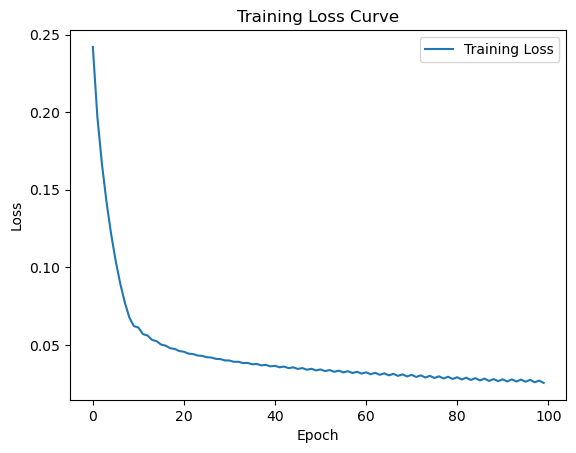

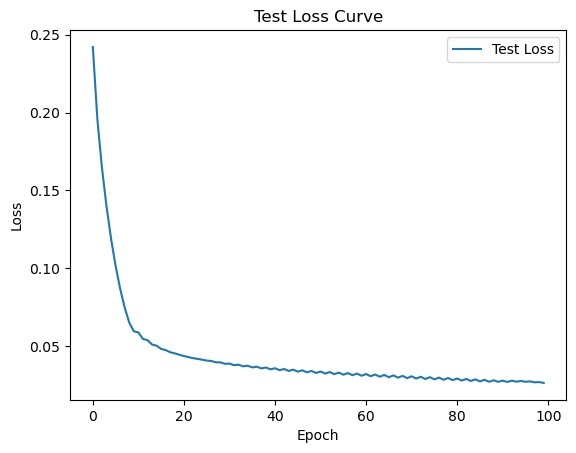

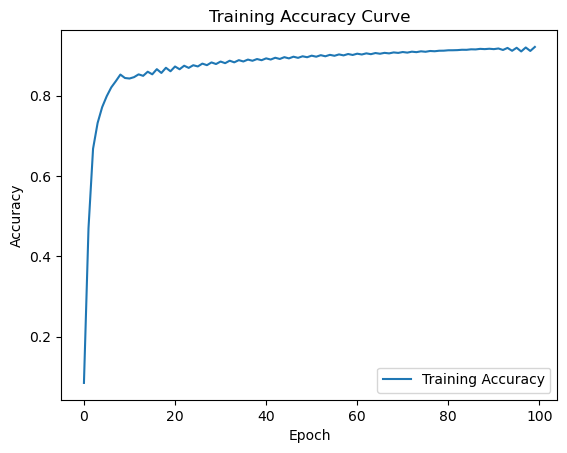

In [7]:
# Define hyperparameters for training 
INPUT_SIZE = 784
HIDDEN_SIZE = [512, 512]
OUTPUT_SIZE = 10            
            
            
# load the dataset  !!! La première fois cela peut prendre quelques minutes !!!!
x_train = mnist.train_images()
x_test = mnist.test_images()

# Applatir les images
x_train = x_train.reshape((60000, 784))
x_test = x_test.reshape((-1, 784))

# Normaliser
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Preprocessing des labels 
y_train = []
for i in mnist.train_labels():
    y_train.append([0  if a!=i else 1 for a in range(0,10)])
y_train = np.array(y_train)

y_test = []
for i in mnist.test_labels():
    y_test.append([0  if a!=i else 1 for a in range(0,10)])
y_test = np.array(y_test)

# initialisation du modèle puis entrainement
nn = Model(input_size=INPUT_SIZE, output_size=OUTPUT_SIZE, hidden_size=HIDDEN_SIZE)
nn.train(x_train, y_train, x_test, y_test, initial_learning_rate=0.001, learning_rate_scheduler=0.001, n_steps=100)